# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Rede-Neural-com-uma-camada-escondida,-reLU-e-Softmax-no-Keras---Iris-dataset" data-toc-modified-id="Rede-Neural-com-uma-camada-escondida,-reLU-e-Softmax-no-Keras---Iris-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Rede Neural com uma camada escondida, reLU e Softmax no Keras - Iris dataset</a></div><div class="lev2 toc-item"><a href="#Objetivos" data-toc-modified-id="Objetivos-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Objetivos</a></div><div class="lev2 toc-item"><a href="#Importação-dos-módulos" data-toc-modified-id="Importação-dos-módulos-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Importação dos módulos</a></div><div class="lev2 toc-item"><a href="#Leitura,-normalização-e-visualização-dos-dados" data-toc-modified-id="Leitura,-normalização-e-visualização-dos-dados-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Leitura, normalização e visualização dos dados</a></div><div class="lev2 toc-item"><a href="#Conversão-dos-rótulos-para-o-formato-one-hot-encoding" data-toc-modified-id="Conversão-dos-rótulos-para-o-formato-one-hot-encoding-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Conversão dos rótulos para o formato one-hot encoding</a></div><div class="lev2 toc-item"><a href="#Construindo-o-modelo-da-rede" data-toc-modified-id="Construindo-o-modelo-da-rede-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Construindo o modelo da rede</a></div><div class="lev3 toc-item"><a href="#Inserção-do-modelo-no-Keras" data-toc-modified-id="Inserção-do-modelo-no-Keras-151"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Inserção do modelo no Keras</a></div><div class="lev2 toc-item"><a href="#Compilação-do-modelo" data-toc-modified-id="Compilação-do-modelo-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Compilação do modelo</a></div><div class="lev2 toc-item"><a href="#Callback-para-visualização-dinâmica" data-toc-modified-id="Callback-para-visualização-dinâmica-17"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Callback para visualização dinâmica</a></div><div class="lev2 toc-item"><a href="#Laço-principal-de-treinamento" data-toc-modified-id="Laço-principal-de-treinamento-18"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Laço principal de treinamento</a></div><div class="lev2 toc-item"><a href="#Imprimindo-loss-e-W-finais" data-toc-modified-id="Imprimindo-loss-e-W-finais-19"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Imprimindo loss e W finais</a></div><div class="lev2 toc-item"><a href="#Avaliação-do-classificador" data-toc-modified-id="Avaliação-do-classificador-110"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Avaliação do classificador</a></div><div class="lev3 toc-item"><a href="#Acurácia" data-toc-modified-id="Acurácia-1101"><span class="toc-item-num">1.10.1&nbsp;&nbsp;</span>Acurácia</a></div><div class="lev3 toc-item"><a href="#Matriz-de-confusão" data-toc-modified-id="Matriz-de-confusão-1102"><span class="toc-item-num">1.10.2&nbsp;&nbsp;</span>Matriz de confusão</a></div><div class="lev2 toc-item"><a href="#Exercícios" data-toc-modified-id="Exercícios-111"><span class="toc-item-num">1.11&nbsp;&nbsp;</span>Exercícios</a></div><div class="lev2 toc-item"><a href="#Principais-aprendizados" data-toc-modified-id="Principais-aprendizados-112"><span class="toc-item-num">1.12&nbsp;&nbsp;</span>Principais aprendizados</a></div>

# Rede Neural com uma camada escondida, reLU e Softmax no Keras - Iris dataset

Este notebook implementa o classificador de 3 classes do conjunto de dados Íris. O classificador é
uma rede neural baseada na regressão logística Softmax visto anteriormente, na qual foi adicionada uma camada escondida de 5 neurônios com ativação não linear reLU.

Agora a rede neural começa a poder separar melhor as fronteiras de decisão, não apenas por segmentos de retas, mas formas não lineares, dando maior flexibilidade na montagem das fronteiras de decisão.

## Objetivos

Os objetivos deste experimento são:
- implementar no Keras uma rede neural clássica com uma camada escondida
- observar durante o treinamento o comportamento dinâmico da função de perda e as fronteiras de decisão
- ver o conceito de callback do Keras, onde se implementa a visualização dinâmica da perda e fronteira de
  decisão durante o treinamento

## Importação dos módulos

O Keras utiliza o gerador pseudoaleatório para gerar os pesos iniciais e efetuar o embaralhamento das
amostras a cada época no gradiente estocástico mini-batch. Para que o gerador pseudoaleatório gere sempre
a mesma sequência, para efeitos de repetibilidade durante a fase de depuração, utiliza-se uma semente, que
deve ser inicializada antes da importação do Keras.

In [1]:
import numpy as np
import numpy.random as nr
nr.seed(12345)            # É importante colocar a semente do gerador pseudoaleatório antes da importação do Keras

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_iris

import keras
from keras.utils import np_utils 
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.optimizers import SGD

from keras.callbacks import Callback
from IPython import display

Using TensorFlow backend.


## Leitura, normalização e visualização dos dados

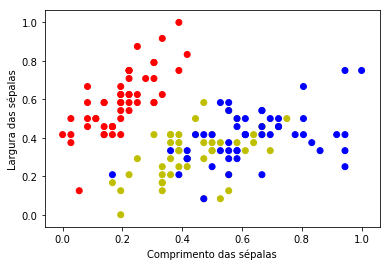

In [2]:
iris = load_iris()
X = iris.data[:,:2]  # comprimento e largura das sépalas, indices 0 e 1
Xc = X - X.min(axis=0)
Xc /= Xc.max(axis=0)

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Comprimento das sépalas')
plt.ylabel('Largura das sépalas')
plt.show()

## Conversão dos rótulos para o formato one-hot encoding

In [3]:
from keras.utils import np_utils 
Y_oh = np_utils.to_categorical(Y, 3) 
print(Y[0:5])
print(Y_oh[0:5])

[0 0 0 0 0]
[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]]


## Construindo o modelo da rede

Para se criar mais camadas no modelo da Regressão Logística visto até agora, precisamos colocar um elemento não linear, caso contrário, a concatenação de não elementos lineares é equivalente a um único elemento linear.

Um dos elementos não lineares mais eficientes e mais utilizados desde 2015 em redes profundas é o denominado `reLU` - *Rectifier Linear Unit*. Para valores negativos de entrada, a saída é zero, para valores positivos, a saída é a mesma.

<img src='../figures/Net2RegressaoSoftmaxArgmaxRede.png',width=600pt>

### Inserção do modelo no Keras
A implementação no Keras de inserção de uma nova camada é muito simples. No exemplo colocamos uma camada escondida de 5 neurônios:

In [4]:
output_dim = nb_classes = 3 
model = Sequential() 

model.add(Dense(5, input_dim=2, activation='relu'))
model.add(Dense(output_dim, activation='softmax')) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 15        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 18        
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


## Compilação do modelo

In [5]:
sgd = SGD(lr=0.1)
model.compile(optimizer=sgd, loss='categorical_crossentropy') 

## Callback para visualização dinâmica

Para poder interceptar a fase de treinamento, que pode ser muito demorada, o Keras possui uma chamada de
`callback` com vários métodos padronizados. Neste exemplo, usamos os métodos `__init__` e `on_epoch_end`
para atualizar a visualização de dois gráficos: o de perda e o de fronteiras de decisão. A célula a
seguir implementa estes dois métodos do `callback`. O gráfico é atualizado a cada 100 épocas.

In [6]:
class BoundaryPlotter(Callback):
    def __init__(self,X,Y,n_epoch, filepath=None,h = .01):
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]
        
        #Inicialização dos gráficos a serem mostrados no final de cada época
        fig = plt.figure(figsize=(30,12))
        plt.subplot(1,2,1)
        plt.xlabel('Epoca',fontsize=28)
        plt.ylabel('Perda',fontsize=28)
        plt.plot(-1,-1,'b',linewidth = 2.0,label = "Treino")
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.xlim(Xc[:,0].min(), Xc[:,0].max())
        plt.ylim(Xc[:,1].min(), Xc[:,1].max())
        plt.xlabel('Comprimento da Sepala',fontsize=28)
        plt.ylabel('Largura da Sépala',fontsize=28)

        
    def on_epoch_end(self,epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])
            if epoch%100==0: # a cada 100 épocas, atualiza os gráficos
                plt.subplot(1,2,1)
                plt.plot(np.arange(epoch+1),self.loss_hist,'b',linewidth = 2.0)
                plt.subplot(1,2,2)
                Z = self.model.predict_classes(self.X_grid,verbose=0).reshape(self.xx.shape)
                plt.figure(1, figsize=(4, 3))
                plt.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                plt.scatter(self.X[:, 0], self.X[:, 1], s=400, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)
                
                display.display(plt.gcf())
                display.clear_output(wait=True)
                

## Laço principal de treinamento

Observe que para o treinamento estamos usando um `batch_size` de 50, que é menor que o número de amostras. 
Este é o gradiente estocástico com mini-batch. O `callback` é inicializado e passado como parâmetro para o
`fit`.

Observe que o fit foi colocado num `try`, permitindo ser interrompido, para sair do laço de treinamento e
continuar. A exceção `KeyboardInterrupt` pode ser gerada selecionando o menu `Kernel->Interrupt` ou
apertando no botão de stop do menu do Jupyter.

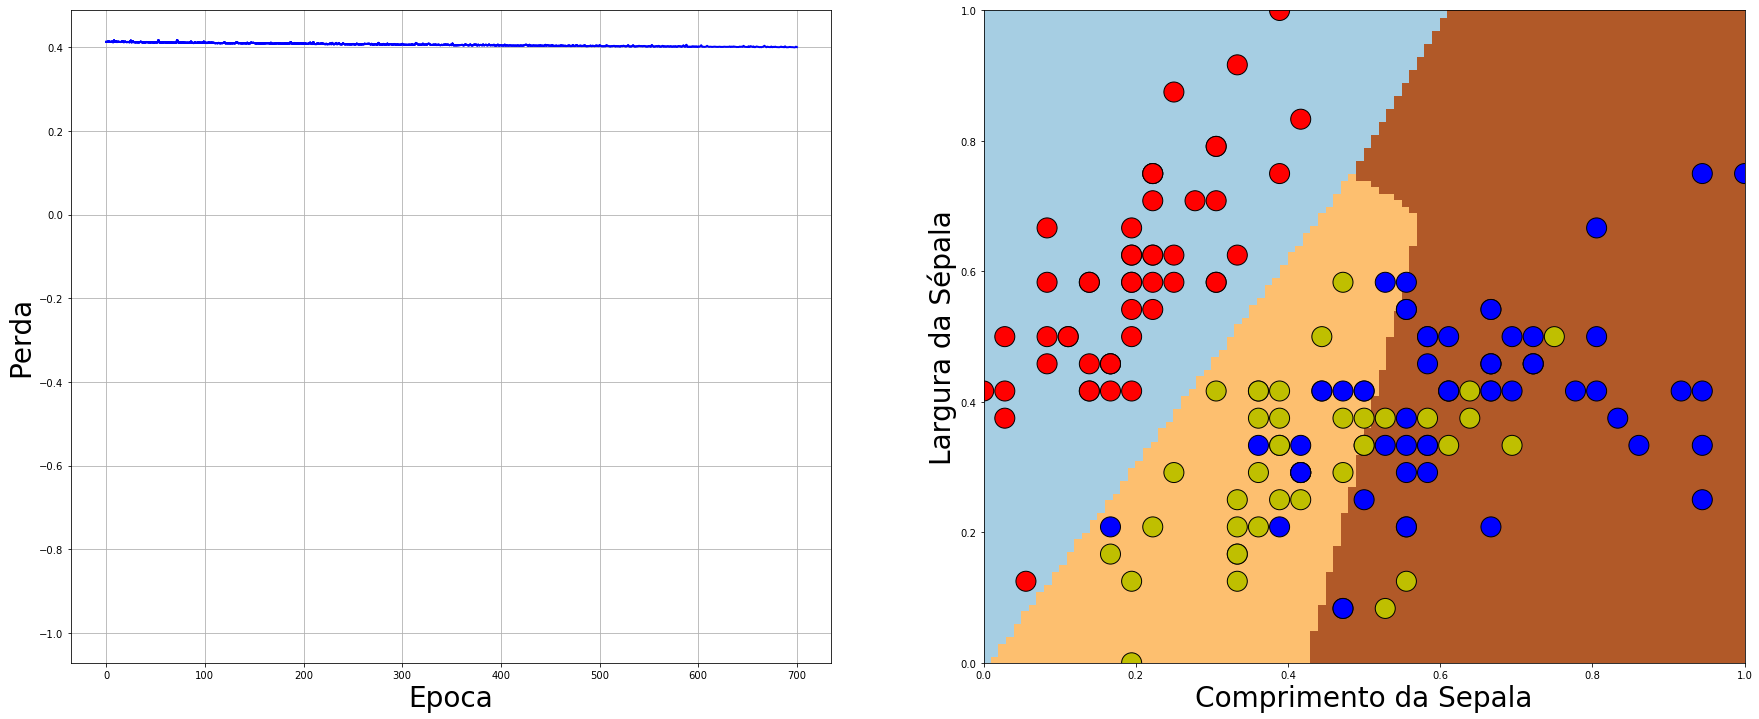

In [10]:
batch_size = 50
nb_epoch = 10000

#Definindo o callback
boundary_plot = BoundaryPlotter(Xc,Y,nb_epoch)

try:
    history = model.fit(Xc, Y_oh, 
                        batch_size=batch_size, 
                        epochs=nb_epoch,
                        callbacks = [boundary_plot],
                        verbose=0)
except KeyboardInterrupt:
    pass

## Imprimindo loss e W finais

Calculamos a perda final utilizando o método `evaluate` e imprimimos os parâmetros treinados
pelo método `get_weights`. 

Observe que neste caso, os pesos estão organizados em uma lista de
4 pesos: 
1. os pesos da primeira camada (2,5) 
2. o bias da primeira camada (3), 
3. em seguida os pesos da camada escondida (5,3) e 
4. finalmente o bias da camada escondida (3), 

totalizando 33 parâmetros treinados, conforme é comprovado pelo sumário da rede mostrado acima.

In [8]:
loss = model.evaluate(Xc, Y_oh, verbose=0)
print('Final loss:',loss)

W = model.get_weights()
for w in W:
    print('w:',w.shape,'\n',w)

Final loss: 0.412375648816
w: (2, 5) 
 [[ 0.27272618 -1.59647059 -3.50100398 -0.38454795 -2.84663796]
 [-0.66192776  1.35189104  0.95932388 -0.10138255  2.53006673]]
w: (5,) 
 [-0.09290868  0.07094721  1.63511431  0.          0.14384468]
w: (5, 3) 
 [[ 0.751625    0.8303988  -0.02789631]
 [ 1.00768673 -1.44438052 -1.17471349]
 [ 2.54826856  0.41532212 -2.89883733]
 [ 0.80129069  0.14705318  0.49921423]
 [ 3.25055051 -2.25378704 -0.53873593]]
w: (3,) 
 [-3.56971073  1.39031243  2.17939687]


## Avaliação do classificador

### Acurácia

In [ ]:
Y_hat = model.predict_classes(Xc)
accuracy = sum(Y_hat == Y)/(float(len(Y)))
print() 
print('Training Accuracy: ', accuracy)

### Matriz de confusão

In [9]:
print('Matriz de confusão:')
import pandas as pd
pd.crosstab(Y_hat, Y)

 32/150 [=====>........................] - ETA: 0s
Training Accuracy:  0.806666666667
Matriz de confusão:


col_0,0,1,2
row_0,,,
0,50,0,0
1,0,31,10
2,0,19,40


## Exercícios

1. Coloque mais uma camada escondida com 10 neurônios e observe o comportamento das fronteiras de decisão.



## Principais aprendizados

